### Graph with LLM + Tool Calling => ReAct Agent!

In [37]:
from langchain_groq import ChatGroq
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

#### Define the Tools

In [38]:
def add(a: int, b: int) -> int:
  """Adds a and b

  Args:
      a: first int
      b: second: int
  """
  return a + b

def multiply(a: int, b: int) -> int:
  """Multiplies a and b

  Args:
      a: first int
      b: second: int
  """
  return a * b

def divide(a: int, b: int) -> int:
  """Divides a and b

  Args:
      a: first int
      b: second: int
  """
  return a / b

# List of mathematical operations for functional use
tools = [add, multiply, divide]

#### Define LLM and power it with tools

In [39]:
llm = ChatGroq(
    model_name="llama3-70b-8192")

# Bind the previously defined tools (functions) to the language model
llm_with_tools = llm.bind_tools(tools)

In [40]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage

# System Message
sys_msg = SystemMessage(content=" You're a helpful assistant tasked with performing arithmetic operations on a given set of inputs.")

# Node with LLM assistant
def assistant(state: MessagesState):
  return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

#### Build and Compile the Graph

In [41]:
builder = StateGraph(MessagesState)

# Our Assistant and Tool Nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

# Compile the Graph
react_graph = builder.compile()

#### Visualize the Graph

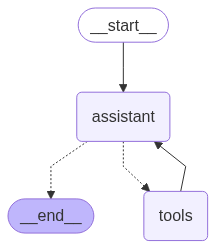

In [42]:
display(Image(react_graph.get_graph().draw_mermaid_png()))

#### Run the Graph

In [43]:
# Define the user input as a dictionary with a list of messages.
input = {"messages": ["Add 7 and 3. Multiply the output by 2. Divide the output by 5"]}

# Invoke the graph with the input messages
messages = react_graph.invoke(input)

# Loop through each message in the output and pretty-print it for readable display.
for m in messages['messages']:
  m.pretty_print()


================================ Human Message =================================

Add 7 and 3. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (0zsf1e75g)
 Call ID: 0zsf1e75g
  Args:
    a: 7
    b: 3
  multiply (xyyvc8fjm)
 Call ID: xyyvc8fjm
  Args:
    a: 10
    b: 2
  divide (zb2qsb2r5)
 Call ID: zb2qsb2r5
  Args:
    a: 20
    b: 5
================================= Tool Message =================================
Name: add

10
================================= Tool Message =================================
Name: multiply

20
================================= Tool Message =================================
Name: divide

4.0
================================== Ai Message ==================================

The final answer is 4.0.


#### Streaming

##### sync

In [44]:
# stream_mode = "values"
input = {"messages": ["Add 7 and 3. Multiply the output by 2. Divide the output by 5"]}

events = react_graph.stream(input=input, stream_mode="values")
for event in events:
    print(event)

{'messages': [HumanMessage(content='Add 7 and 3. Multiply the output by 2. Divide the output by 5', additional_kwargs={}, response_metadata={}, id='13e4088f-fd72-4fb1-b90d-d64ec6b530c6')]}
{'messages': [HumanMessage(content='Add 7 and 3. Multiply the output by 2. Divide the output by 5', additional_kwargs={}, response_metadata={}, id='13e4088f-fd72-4fb1-b90d-d64ec6b530c6'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '7fhn9w1zb', 'function': {'arguments': '{"a":7,"b":3}', 'name': 'add'}, 'type': 'function'}, {'id': 'e6mqv8db8', 'function': {'arguments': '{"a":10,"b":2}', 'name': 'multiply'}, 'type': 'function'}, {'id': '6hxn9pvcm', 'function': {'arguments': '{"a":20,"b":5}', 'name': 'divide'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1204, 'total_tokens': 1290, 'completion_time': 0.315317957, 'prompt_time': 0.046225555, 'queue_time': 0.010529169999999997, 'total_time': 0.361543512}, 'model_name': 'llama3-70b-

In [45]:
# stream_mode = "values"
input = {"messages": ["Add 7 and 3. Multiply the output by 2. Divide the output by 5"]}

events = react_graph.stream(input=input, stream_mode="updates")
for event in events:
    print(event)

{'assistant': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '85xwayz0f', 'function': {'arguments': '{"a":7,"b":3}', 'name': 'add'}, 'type': 'function'}, {'id': 'vwd60wwxj', 'function': {'arguments': '{"a":10,"b":2}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'nb68pvwmc', 'function': {'arguments': '{"a":20,"b":5}', 'name': 'divide'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1204, 'total_tokens': 1290, 'completion_time': 0.308637374, 'prompt_time': 0.04645249, 'queue_time': 0.019925477999999996, 'total_time': 0.355089864}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--852e8838-3846-4941-804a-3fe43c5de98f-0', tool_calls=[{'name': 'add', 'args': {'a': 7, 'b': 3}, 'id': '85xwayz0f', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 10, 'b': 2}, 'id': 'vwd60wwxj', 'type': 'tool

##### async

In [46]:
# version = "v2"
input = {"messages": ["Hi How're you?"]}

events = react_graph.astream_events(input=input, version='v2')
async for event in events:
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ["Hi How're you?"]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '84533360-a902-44a3-8fd7-2e646ab2ee7e', 'metadata': {}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content="Hi How're you?", additional_kwargs={}, response_metadata={}, id='d43237ca-3e80-420e-a219-1a0461028ad3')]}}, 'name': 'assistant', 'tags': ['graph:step:1'], 'run_id': 'aa7b5768-1ec4-4c91-a495-5779c5f2f926', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'assistant', 'langgraph_triggers': ('branch:to:assistant',), 'langgraph_path': ('__pregel_pull', 'assistant'), 'langgraph_checkpoint_ns': 'assistant:4c4bbd3b-3b10-2956-7365-4f51661b3049'}, 'parent_ids': ['84533360-a902-44a3-8fd7-2e646ab2ee7e']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[SystemMessage(content=" You're a helpful assistant tasked with performing arithmetic operations on a given set of inputs.", additional_kwargs={}, respon

In [52]:
input = {"messages": ["Hi How're you?"]}

events = react_graph.astream_events(input=input, version='v2')
async for event in events:
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end='', flush=True)

I'm doing well, thanks! How can I assist you today?